In [46]:
from __future__ import print_function

import glob
bam_filenames = glob.glob('/home/obotvinnik/projects/singlecell_pnms/analysis/bams_from_aws/*.bam')

sample_id = 'M2_02'

bam_filename = [x for x in bam_filenames if sample_id in x][0]
bam_filename

'/home/obotvinnik/projects/singlecell_pnms/analysis/bams_from_aws/M2_02_R1.fastq.gz.polyATrim.adapterTrim.rmRep.sorted.rg.bam'

In [47]:
# figwidth = 4
# figheight = len(bam_filenames) * 1
# figsize = figwidth, figheight
# print figsize

In [48]:
import pysam
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk')

%matplotlib inline

In [50]:
type(read)

HTSeq._HTSeq.SAM_Alignment

In [6]:
pysam.__version__

'0.8.3'

In [7]:
from outrigger.region import Region

snap25_mxe_event = 'exon:chr20:10265372-10265420:+@exon:chr20:10273530-10273647:+@exon:chr20:10273809-10273926:+@exon:chr20:10277573-10277698:+'

snap25_exons = snap25_mxe_event.split('@')
snap25_regions = map(Region, snap25_exons)
snap25_regions

In [9]:
import HTSeq

In [10]:
bam_htseq = HTSeq.BAM_Reader(bam_filename)

In [11]:
bam_htseq?

In [12]:
!samtools index $bam_filename

In [13]:
# exon1 = snap25_regions[0]

# list(bam_htseq[HTSeq.GenomicInterval(snap25_regions[0].chrom, snap25_regions[0].start, 
#                                      snap25_regions[-1].stop, snap25_regions[0].strand)])

In [14]:
import numpy as np

In [15]:
HTSeq.cigar_operation_names

{'D': 'deleted',
 'H': 'hard-clipped',
 'I': 'inserted',
 'M': 'matched',
 'N': 'skipped',
 'P': 'padded',
 'S': 'soft-clipped'}

In [16]:
INSERTION_DELETIONS = ('I', 'D')


def skip_bad_cigar(read, bam_filename, bad_cigar=INSERTION_DELETIONS):
    # Skip reads with no CIGAR string
    if read.cigar is None:
        print("Skipping read with no CIGAR string: {read_name} (from {bam})".format(
                read_name=read.read.name, bam=bam_filename))
        return

    # Check if the read contains an insertion (I)
    # or deletion (D) -- if so, skip it
    for cigar_operation in read.cigar:
        cigar = cigar_operation.type
        if cigar in bad_cigar:
            print("Skipping read with CIGAR string {abbrev} (a base in the read was {full}): {read_name} (from {bam})".format(
                read_name=read.read.name, bam=bam_filename, abbrev=cigar, 
                    full=HTSeq.cigar_operation_names[cigar]))
            return
    return read


In [17]:


def count_region_reads(bam_htseq, bam_filename, chrom, start, stop, strand,
                       allowed_cigar=('M'), bad_cigar=('I', 'D'), offset=True):
    """Get the number of reads that matched to the reference sequence
    
    Parameters
    ----------
    bam_htseq : HTSeq.BAM_Reader
        Bam file object to get reads from
    bam_filename : str
        Name of the bam filename for logging purposes
    chrom : str
        Name of the reference chromosome
    start, stop : int
        Genome-based locations of the start and stop regions
    pad : int, optional
        Add a few nucleotides to the left and right of the array for
        visually pleasing padding. (default=10)
    allowed_cigar : tuple of str, optional
        Which CIGAR string flags are allowed. (default=('M') aka match)
    bad_cigar : tuple of str, optional
        Which CIGAR string flags are not allowed. (default=('I', 'D') aka 
        insertion and deletion)
    offset : bool, optional
        If True, offset the region counts so that the array starts at zero 
        and not the whole chromosome. Useful for plotting just the one region.
        (default=True)
    
    Returns
    -------
    counts : numpy.array
        Number of reads that matched to the genome at every location
    """

    # Add a small amount of nucleotides to left and right for making the plot look nice
#     start = start - pad
#     stop = stop + pad
    
    length = stop - start + 1 if offset else stop

    counts = np.zeros(shape=(length), dtype=int)
    
    region_reads = bam_htseq[HTSeq.GenomicInterval(chrom, start, stop, strand)]

    print('start:', start)
    
    for read in region_reads:
        read = skip_bad_cigar(read, bam_filename, bad_cigar)
        if read is None:
            continue
        for cigar_operation in read.cigar:
            # Only count where the read matched to the genome
            if cigar_operation.type not in allowed_cigar:
                continue
            match_start = cigar_operation.ref_iv.start
            match_stop = cigar_operation.ref_iv.end
            
            if offset:
                match_start = match_start - start
                match_stop = match_stop - start
                
            if match_stop < 0:
                # If the match_stop is negative, that means we have the other read of the paired end read
                # that mapped to somewhere else in the genome
                continue
            match_start = max(match_start, 0)
            match_stop = min(match_stop, length)

            counts[match_start:match_stop] += 1
    return counts


chrom = snap25_regions[0].chrom
start = snap25_regions[0].start
stop = snap25_regions[-1].stop
strand = snap25_regions[0].strand

snap25_counts = count_region_reads(bam_htseq, bam_filename, chrom, start, stop, strand)
snap25_counts

start: 10265372
Skipping read with CIGAR string D (a base in the read was deleted): HWI-ST1001:211:C1PUCACXX:8:2204:7788:53829 (from /home/obotvinnik/projects/singlecell_pnms/analysis/bams_from_aws/M2_02_R1.fastq.gz.polyATrim.adapterTrim.rmRep.sorted.rg.bam)


array([80, 80, 80, ..., 89, 87,  5])

[(0, 12327)]

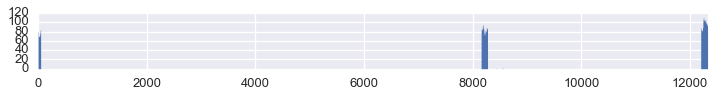

In [18]:
fig, ax = plt.subplots(figsize=(12, 1))

xmax = snap25_counts.shape[0]
xvalues = np.arange(0, xmax)

ax.fill_between(xvalues, snap25_counts, y2=0, linewidth=0);
ax.set(xlim=(0, xmax))

In [19]:
from collections import defaultdict, Counter

In [20]:
def pad_location(start, stop, pad):
    start = start - pad
    stop = stop + pad
    return start, stop

In [21]:
region_reads = bam_htseq[HTSeq.GenomicInterval(chrom, start, stop, strand)]
bad_cigar = INSERTION_DELETIONS

junctions = Counter()

# pad = 10
# start, stop = pad_location(start, stop, pad)

length = stop - start + 1

for read in region_reads:
#     read = skip_bad_cigar(read, bam_filename, bad_cigar)
    if read is None:
        continue
    for cigar_operation in read.cigar:
        # N = did not match to genome and is an insertion
        if cigar_operation.type == 'N':
            junction_start = cigar_operation.ref_iv.start - start
            junction_stop = junction_start + cigar_operation.ref_iv.length #- start
            if (junction_stop < 0) or (junction_stop > length):
                continue
            
#             print(junction_start, junction_stop, cigar_operation.ref_iv.length, 
#                   cigar_operation.ref_iv.start,
#                   cigar_operation.ref_iv.end)
            junctions[(junction_start, junction_stop)] += 1
junctions

Counter({(48, 8157): 78, (48, 8436): 2, (8275, 12200): 82, (8554, 12200): 2})

In [22]:
def count_junctions(bam, chrom, start, stop, strand, bad_cigar=INSERTION_DELETIONS, offset=True):
    region_reads = bam[HTSeq.GenomicInterval(chrom, start, stop, strand)]
    junctions = Counter()

    length = stop - start + 1

    for read in region_reads:
        if read is None:
            continue
        for cigar_operation in read.cigar:
            # N = did not match to genome and is an insertion
            if cigar_operation.type == 'N':
                junction_start = cigar_operation.ref_iv.start
                
                if offset:
                    junction_start -= start
                    
                junction_stop = junction_start + cigar_operation.ref_iv.length
                
                if (junction_stop < 0) or (junction_stop > length):
                    # If any of the junctions start or end outside of the region, skip it
                    continue
                junctions[(junction_start, junction_stop)] += 1
    return junctions

In [23]:

def cubic_bezier(points, t):
    """
    Get points in a cubic bezier.
    """
    p0, p1, p2, p3 = points
    p0 = np.array(p0)
    p1 = np.array(p1)
    p2 = np.array(p2)
    p3 = np.array(p3)
    return p0 * (1 - t)**3 + 3 * t * p1 * (1 - t) ** 2 + \
        3 * t**2 * (1 - t) * p2 + t**3 * p3

In [24]:
import matplotlib as mpl

In [25]:
mpl.artist.Path

matplotlib.path.Path

In [26]:
ymin = 1

A bezier curve is specified by four points:

![](http://matplotlib.org/_images/path_tutorial-2.png)

8275 12200
	 83 88
		 [(8275, 83), (8275, 93), (12200, 98), (12200, 88)]
8554 12200
	 2 88
		 [(8554, 2), (8554, 12), (12200, 98), (12200, 88)]
48 8157
	 84 77
		 [(48, 84), (48, 94), (8157, 87), (8157, 77)]
48 8436
	 84 2
		 [(48, 84), (48, 94), (8436, 12), (8436, 2)]


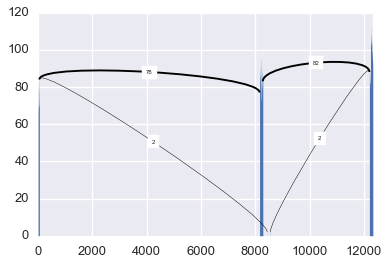

In [27]:
from matplotlib.artist import Path
from matplotlib.patches import PathPatch

fig, ax = plt.subplots()
xmax = snap25_counts.shape[0]
xvalues = np.arange(0, xmax)

ax.fill_between(xvalues, snap25_counts, y2=0, linewidth=0);
ax.set(xlim=(0, xmax))


for (left, right), n_junction_reads in junctions.items():
    print(left, right)
#     midpoint = (right - left)/2
    curve_height = 10 # 3 * float(ymin) / 4
    
    
    left_height = snap25_counts[left-1]
    right_height = snap25_counts[right+1]
    print('\t', left_height, right_height)
    vertices = [(left, left_height), 
                (left, left_height + curve_height), 
                (right, right_height + curve_height), 
                (right, right_height)]
    print('\t\t', vertices)
    codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]
    midpoint = cubic_bezier(vertices, 0.5)
    
    if n_junction_reads:
        plt.text(midpoint[0], midpoint[1], '{}'.format(n_junction_reads),
             fontsize=6, ha='center', va='center', backgroundcolor='w')

    path = Path(vertices, codes)
    patch = PathPatch(path, ec='black', lw=np.log10(n_junction_reads + 1), fc='none')
    ax.add_patch(patch)
    
#     xs, ys = zip(*vertices)
#     ax.plot(xs, ys, 'x--', lw=2, color='black', ms=10)

#     for i, (x, y) in enumerate(zip(xs, ys)):
#         ax.text(x, y, 'P{}'.format(i))
#     ax.text(0.15, 1.05, 'P1')
#     ax.text(1.05, 0.85, 'P2')
#     ax.text(0.85, -0.05, 'P3')


In [28]:
def junctionplot(left, right, n_junction_reads, read_counts, curve_height_multiplier=0.1, #curve_height=10, 
                 color=None,
                 text_kws=dict(fontsize=6, horizontalalignment='center', verticalalignment='center', backgroundcolor='w'),
                 linewidth_function=lambda x: np.log10(x + 1),
                 patch_kws=dict(facecolor='none',)):
    """
    
    Uses the y-axis limits to determine the curve height so make sure to use this function AFTER 
    
    Parameters
    ----------
    
    patch_kws : dict
        To change the color of the line, use the "edgecolor" keyword, e.g. dict(edgecolor="black")
    """
    ymin, ymax = ax.get_ylim()
    yrange = ymax - ymin
    curve_height = yrange * curve_height_multiplier
    
    left_height = read_counts[left-1]
    right_height = read_counts[right+1]
#     print('\t', left_height, right_height)
    vertices = [(left, left_height), 
                (left, left_height + curve_height), 
                (right, right_height + curve_height), 
                (right, right_height)]
#     print('\t\t', vertices)
    codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]
    midpoint = cubic_bezier(vertices, 0.5)
    
    if n_junction_reads:
        plt.text(midpoint[0], midpoint[1], '{}'.format(n_junction_reads), **text_kws)

    path = Path(vertices, codes)
    
    patch_kws['linewidth'] = linewidth_function(n_junction_reads)
    if color is not None:
        patch_kws['edgecolor'] = color
    patch = PathPatch(path, **patch_kws)
    return ax.add_patch(patch)


In [29]:
color = 'steelblue'

In [30]:
snap25_counts_log = np.log10(snap25_counts+1)
snap25_counts_log

array([ 1.90848502,  1.90848502,  1.90848502, ...,  1.95424251,
        1.94448267,  0.77815125])

In [40]:
def coverageplot(counts, color, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    xmax = counts.shape[0]
    xvalues = np.arange(0, xmax)
#     ax.set(xlim=(0, xmax))
    
    return ax.fill_between(xvalues, counts, y2=0, linewidth=0, color=color, **kwargs)

[[<matplotlib.axis.YTick at 0x2b8e27320990>,

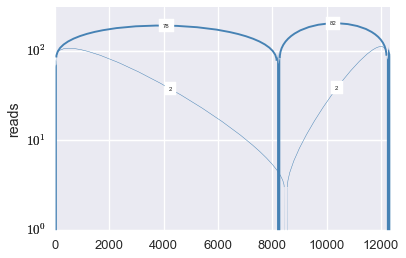

In [31]:
fig, ax = plt.subplots()
xmax = snap25_counts.shape[0]
xvalues = np.arange(0, xmax)

ax.fill_between(xvalues, snap25_counts_log, y2=0, linewidth=0, color=color);
ax.set(xlim=(0, xmax))

ymin, ymax = ax.get_ylim()
yrange = ymax - ymin

for (left, right), n_junction_reads in junctions.items():
    junctionplot(left, right, n_junction_reads, snap25_counts_log, color=color, curve_height_multiplier=0.2)
yticks = map(int, ax.get_yticks())
yticklabels = ('$10^{}$'.format(y) for y in yticks)
ax.set(yticks=yticks, yticklabels=yticklabels, ylabel='reads')

In [41]:
# class WasabiPlotter(object):
    
#     def __init__(bam_filename, chrom, start, stop, log_base, ax):
#         self.

def wasabiplot(bam_filename, chrom, start, stop, strand, log_base=10, ax=None):
    bam = HTSeq.BAM_Reader(bam_filename)
    counts = count_region_reads(bam, bam_filename, chrom, start, stop, strand)
    counts = np.log(counts)/np.log(log_base)
    
    if ax is None:
        ax = plt.gca()
        
    coverageplot(counts, color, ax)

    ymin, ymax = ax.get_ylim()
    yrange = ymax - ymin

    junctions = count_junctions(bam, chrom, start, stop, strand)
    
    for (left, right), n_junction_reads in junctions.items():
        junctionplot(left, right, n_junction_reads, counts, color=color, curve_height_multiplier=0.2)
    yticks = map(int, ax.get_yticks())
    yticklabels = ('$10^{}$'.format(y) for y in yticks)
    ax.set(yticks=yticks, yticklabels=yticklabels, ylabel='reads')

In [42]:
bam_filename2 = [x for x in bam_filenames if 'M2_03' in x][0]

In [43]:
! ls $bam_filename2*

/home/obotvinnik/projects/singlecell_pnms/analysis/bams_from_aws/M2_03_R1.fastq.gz.polyATrim.adapterTrim.rmRep.sorted.rg.bam
/home/obotvinnik/projects/singlecell_pnms/analysis/bams_from_aws/M2_03_R1.fastq.gz.polyATrim.adapterTrim.rmRep.sorted.rg.bam.bai


start: 10265372
Skipping read with CIGAR string I (a base in the read was inserted): HWI-ST1001:211:C1PUCACXX:8:2302:5344:69707 (from /home/obotvinnik/projects/singlecell_pnms/analysis/bams_from_aws/M2_03_R1.fastq.gz.polyATrim.adapterTrim.rmRep.sorted.rg.bam)
Skipping read with CIGAR string D (a base in the read was deleted): HWI-ST1001:211:C1PUCACXX:8:2312:7987:8949 (from /home/obotvinnik/projects/singlecell_pnms/analysis/bams_from_aws/M2_03_R1.fastq.gz.polyATrim.adapterTrim.rmRep.sorted.rg.bam)
Skipping read with CIGAR string D (a base in the read was deleted): HWI-ST1001:211:C1PUCACXX:8:2205:8970:2276 (from /home/obotvinnik/projects/singlecell_pnms/analysis/bams_from_aws/M2_03_R1.fastq.gz.polyATrim.adapterTrim.rmRep.sorted.rg.bam)


/home/obotvinnik/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


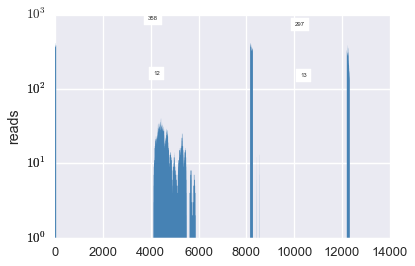

In [45]:
wasabiplot(bam_filename2, chrom, start, stop, strand)

In [ ]:
cigar_operation.ref_iv.start

In [ ]:
cigar_operation = read.cigar[1]
cigar_operation

In [ ]:
cigar_operation.ref_iv.start

In [ ]:
cigar_operation.ref_iv.length

In [ ]:
cigar_operation.ref_iv.end

In [ ]:
stop

In [ ]:
cigar_operation.ref_iv.end_d

In [ ]:
cigar_operation.ref_iv.end

In [ ]:
cigar_operation.ref_iv.start

In [ ]:
cigar_operation.check()

In [ ]:
read.iv.start

In [ ]:
# subset_reads = bam.fetch(reference=exon1.chrom, start=snap25_regions[0].start, end=snap25_regions[-1].stop)
# subset_reads

Junction plotting code:

```python
for jxn in jxns:
    leftss, rightss = map(int, jxn.split(":"))

    ss1, ss2 = [graphcoords[leftss - tx_start - 1],\
        graphcoords[rightss - tx_start]]

    mid = (ss1 + ss2) / 2
    h = -3 * ymin / 4

    numisoforms = 0
    for i in range(len(mRNAs)):
        if leftss in sslists[i] and \
            rightss in sslists[i]:
            numisoforms += 1
    if numisoforms > 0:
        if numisoforms % 2 == 0: # put on bottom 
            pts = [(ss1, 0), (ss1, -h), (ss2, -h), (ss2, 0)]
            midpt = cubic_bezier(pts, .5)
        else:                         # put on top 
            leftdens = wiggle[leftss - tx_start - 1]
            rightdens = wiggle[rightss - tx_start]

            pts = [(ss1, leftdens),
                   (ss1, leftdens + h),
                   (ss2, rightdens + h),
                   (ss2, rightdens)]
            midpt = cubic_bezier(pts, .5)

        if number_junctions:
            text(midpt[0], midpt[1], '%s'%(jxns[jxn]),
                 fontsize=6, ha='center', va='center', backgroundcolor='w')

        a = Path(pts, [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
        p = PathPatch(a, ec=color, lw=log(jxns[jxn] + 1) /\
            log(junction_log_base), fc='none')
        axvar.add_patch(p) 
```

Code to get read counts and junctions

```python
def readsToWiggle_pysam(reads, tx_start, tx_end):
    """
    Convert reads to wiggles; uses pysam.
    """
    wiggle = zeros((tx_end - tx_start + 1), dtype='f')
    jxns = {}
    for read in reads:
        # Skip reads with no CIGAR string
        if read.cigar is None:
            print "Skipping read with no CIGAR string: %s" %(read.cigar)
            continue
        cigar_str = sam_utils.sam_cigar_to_str(read.cigar)

        if ("N" in cigar_str) and (cigar_str.count("N") > 1):
            print "Skipping read with multiple junctions crossed: %s" \
                  %(cigar_str)
            continue

        # Check if the read contains an insertion (I)
        # or deletion (D) -- if so, skip it
        for cigar_part in read.cigar:
            if cigar_part[0] == 1 or \
               cigar_part[1] == 2:
                print "Skipping read with CIGAR %s" \
                      %(cigar_str)
        aligned_positions = read.positions
        for i, pos in enumerate(aligned_positions):
            if pos < tx_start or pos > tx_end:
#                print "=>",pos
                continue
            wig_index = pos-tx_start
            wiggle[wig_index] += 1./read.qlen
            try:
                # if there is a junction coming up                
                if aligned_positions[i+1] > pos + 1: 
                    leftss = pos+1
                    rightss= aligned_positions[i+1]+1
                    if leftss > tx_start and leftss < tx_end \
                           and rightss > tx_start and rightss < tx_end:                      
                        jxn = ":".join(map(str, [leftss, rightss]))
                        try:
                            jxns[jxn] += 1 
                        except:
                            jxns[jxn] = 1
            except:
                pass
    return wiggle, jxns
```